# 第20讲 作业


- 提交文件名
    - `学号_20讲作业.ipynb`

## 关于 `Titanic` 号乘客丢失年龄的考虑


- 对于丢失年龄的乘客，课件中采用 `全部未丢失年龄的平均值` 来补充（如下代码格）

In [ ]:
mean = titanic['age'].mean()                 # 平均年龄
titanic['age'].fillna(mean, inplace=True)    # 填充

## 问题


- 想想这种处理方法是否可以改进，说明理由？

## 解题思路1——回归
* 通过已有的数据构建起年龄和其他特征的关系模型
* 通过建立的模型预测缺失的年龄

## 解题思路2——聚类
* 试图将乘客分成不同类
* 每一类的乘客中必定有缺失和不缺失年龄信息的乘客
* 在每一类中，缺失的年龄信息按照该类中已知年龄乘客的年龄平均值填充

In [87]:
import IPython
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, datasets
from sklearn import feature_extraction

### 导入数据

In [88]:
titanic = pd.read_csv('data/titanic.csv')
titanic_array=np.array(titanic)
feature_names =np.array(titanic.columns)
print(feature_names,'\n')

['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest'
 'room' 'ticket' 'boat' 'sex'] 



### 观察各个属性的缺失数据条目数

In [89]:
nan_array=np.vstack([(100*titanic.isna().sum()/len(titanic)), (titanic.isna().sum())])
nan_df = pd.DataFrame(np.transpose(nan_array),index=feature_names,columns = ['nan(%)','nan_sum'])
nan_df

,nan(%),nan_sum
row.names,0.000000,0.0
pclass,0.000000,0.0
survived,0.000000,0.0
name,0.000000,0.0
age,51.789794,680.0
embarked,37.471439,492.0
home.dest,42.574257,559.0
room,94.135567,1236.0
ticket,94.744859,1244.0
boat,73.571973,966.0


- 属性room,ticket,boat的缺失条目数量巨大

### 观察每个属性的非重复值

In [90]:
unique_data=np.zeros((len(feature_names),1))
for i in  range(len(feature_names)):
    unique_data[i]=len(titanic[feature_names[i]].unique())
df_unique_data=pd.DataFrame(unique_data,index =feature_names,columns=['num of unique'])
df_unique_data

,num of unique
row.names,1313.0
pclass,3.0
survived,2.0
name,1310.0
age,74.0
embarked,4.0
home.dest,372.0
room,54.0
ticket,42.0
boat,100.0


### 观察上面的表格
* 发现特征属性name,home.dest,room,ticket的非重复值众多
* 原因也很简单，名字各不相同，每个人的出发地和目的地组合多种多用，船上房间众多，票的种类也众多
* 此数据集总量本身不大——1313，如果考虑到待会要训练其他特征来预测空缺的年龄属性，训练集只有500左右
* 所以结合实际与年龄有关的因素，并且考虑到每种属性的缺失条目数，放弃对于训练作用不大的属性——name,home.dest,room,ticket,boat

In [91]:
titanic_new=titanic.drop(feature_names[[0,3,6,7,8,9]], axis='columns') 
titanic_data=np.array(titanic_new)
nan_df_new = pd.DataFrame(titanic_new.isnull().sum())
nan_df_new.columns = ['nanSum']
nan_df_new

,nanSum
pclass,0
survived,0
age,680
embarked,492
sex,0


### 删除缺失数据条目

In [92]:
titanic_clear = titanic_new.copy()
titanic_clear=titanic_clear.dropna(how="any")
print("清理后的数据条目数：",len(titanic_clear))
titanic_clear.tail()

清理后的数据条目数： 627


,pclass,survived,age,embarked,sex
833,3rd,0,32.0,Southampton,male
835,3rd,0,20.0,Southampton,male
836,3rd,0,37.0,Southampton,male
837,3rd,0,28.0,Southampton,male
838,3rd,0,19.0,Southampton,male


### 转换特征工具 one_hot

In [93]:
def one_hot_dataframe(data, cols, replace=False):
    """ 
    取数据帧和有待解码的若干列
    返回：数据data、向量化数据，以及拟合的向量化器
    """
    vec = feature_extraction.DictVectorizer()                   # 生成 DictVectorizer 对象
    mkdict = lambda row: dict((col, row[col]) for col in cols) # 映射：列标识 -> 行的对应元素
    
    vecData = pd.DataFrame(vec.fit_transform(data[cols].apply(mkdict, axis=1)).toarray()) # 重构数据帧
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    
    if replace is True:
        data = data.drop(cols, axis=1)
        data = data.join(vecData)

    return (data, vecData)

In [94]:
titanic_onehot, titanic_n = one_hot_dataframe(titanic_clear, ['pclass', 'survived', 'embarked', 'sex'], replace=True)
titanic_onehot.tail()

,age,embarked=Cherbourg,embarked=Queenstown,embarked=Southampton,pclass=1st,pclass=2nd,pclass=3rd,sex=female,sex=male,survived
833,32.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
835,20.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
836,37.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
837,28.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
838,19.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [95]:
titanic_onehot.describe()

,age,embarked=Cherbourg,embarked=Queenstown,embarked=Southampton,pclass=1st,pclass=2nd,pclass=3rd,sex=female,sex=male,survived
count,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000
mean,31.034955,0.212121,0.049442,0.738437,0.350877,0.338118,0.311005,0.382775,0.617225,0.441786
std,14.686036,0.409137,0.216962,0.439837,0.477626,0.473447,0.463274,0.486452,0.486452,0.496996
min,0.166700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,40.500000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,71.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 相关性分析

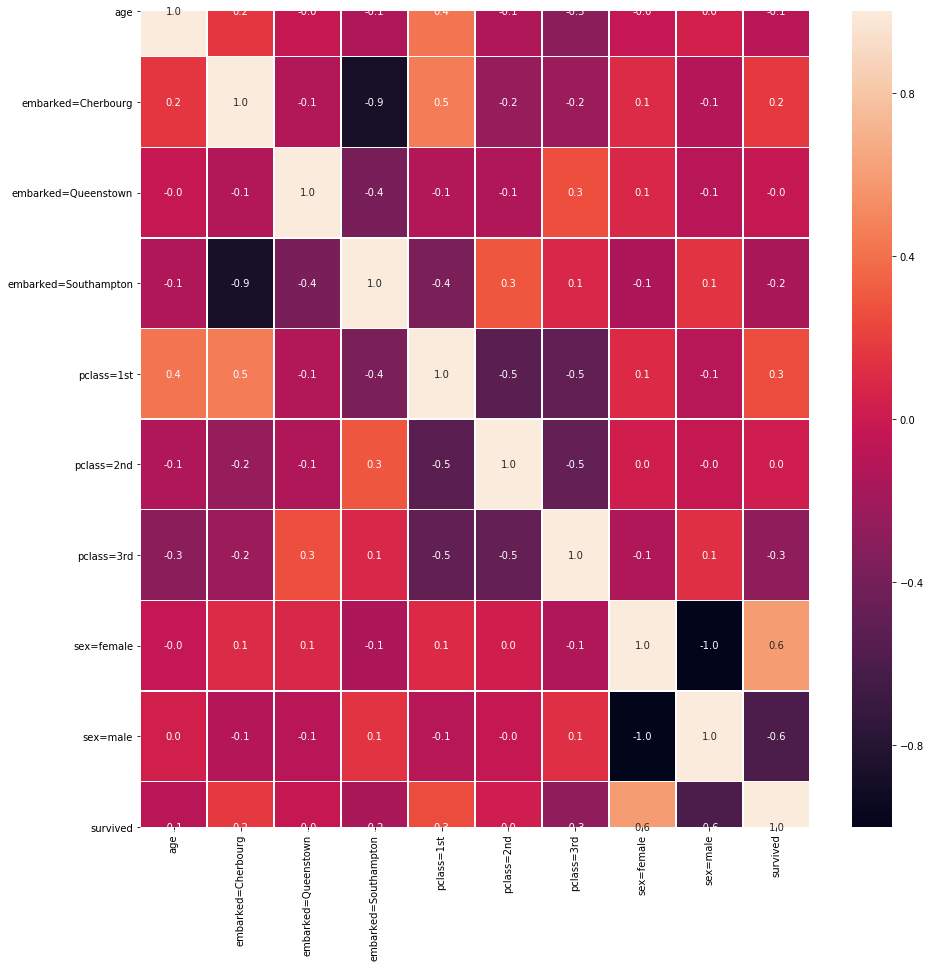

In [96]:
f,ax = plt.subplots(figsize=(15, 15))
corelation=titanic_onehot.corr()
sns.heatmap(corelation,xticklabels=corelation.columns,yticklabels=corelation.columns, 
            annot=True, linewidths=.5, fmt= '.1f',ax=ax)

#### 分析上图
* 总体而言年龄与其他特征关联性均很弱
* 年龄和性别几乎没有任何关系
* 年龄与幸存之间的关系很弱，本以为幸存下来多为年轻人，应当有较强关系
* 年龄与是否为一等舱有较强关系
* 年龄与登船地点关系也不大

In [97]:
titanic_aftercorelation=titanic_onehot.drop(['sex=female','sex=male','embarked=Cherbourg','embarked=Queenstown','embarked=Southampton'], axis='columns') 
titanic_aftercorelation_data=np.array(titanic_aftercorelation)

## 回归方法
### 随机森林回归

In [98]:
from sklearn.ensemble import RandomForestRegressor
# 设定森林中有6棵树
forest = RandomForestRegressor(n_estimators = 15, random_state = 34 )

In [99]:
feature_aftercorelation=titanic_aftercorelation.columns
feature_aftercorelation

Index(['age', 'pclass=1st', 'pclass=2nd', 'pclass=3rd', 'survived'], dtype='object')

In [100]:
data_y=np.array(titanic_aftercorelation['age'])
data_X=np.array(titanic_aftercorelation[feature_aftercorelation[1:]])

In [101]:
from sklearn.model_selection import cross_val_score, KFold
def train_and_evaluate(regr, X_train, y_train):
    regr.fit(X_train, y_train)  # 训练
    print ("在训练集上，决定系数：", regr.score(X_train, y_train))
    # 创建 K-折
    cv = KFold(5, shuffle=True, random_state=33)                     # model_selection 模块用
    #cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)  # cross_validation 模块用
    scores = cross_val_score(regr, X_train, y_train, cv=cv)
    print ("使用 K-折交叉验证的 平均决定系数:",np.mean(scores))

In [102]:
def visualization_for_predict_data(data_observed, data_predicted, label_observed, label_predicted,title):
    plt.scatter(data_observed, data_predicted)
    max_v = np.max([data_predicted] + [data_observed]) * 1.1
    min_v = np.min([data_predicted] + [data_observed]) * 1.1
    plt.plot([min_v,max_v], [min_v,max_v], "r-")
    plt.title(title)
    plt.xlabel(label_observed)
    plt.ylabel(label_predicted)

In [103]:
train_and_evaluate(forest,data_X,data_y)

在训练集上，决定系数： 0.2408145827937067
使用 K-折交叉验证的 平均决定系数: 0.22853234978767983


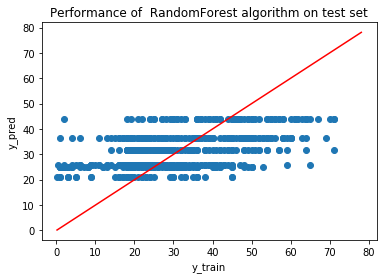

In [104]:
pred_y1 = forest.predict(data_X)
visualization_for_predict_data(data_y,pred_y1, "y_train", "y_pred","Performance of  RandomForest algorithm on test set")

### 线性回归

In [105]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,normalize=False)

In [106]:
train_and_evaluate(LR,data_X,data_y)

在训练集上，决定系数： 0.239610631671911
使用 K-折交叉验证的 平均决定系数: 0.23339068377956734


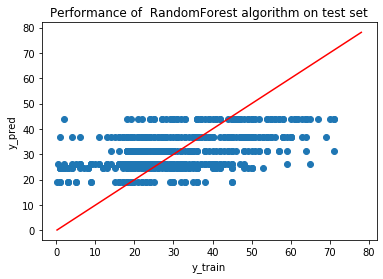

In [107]:
pred_y2 = LR.predict(data_X)
visualization_for_predict_data(data_y,pred_y2, "y_train", "y_pred","Performance of  RandomForest algorithm on test set")

### 结果分析
* 以上两种回归方法均不太理想
* 因为本身其他特征与年龄的关联性并不大

### 采用回归方法对缺失数据进行填充

In [108]:
titanic_fill=titanic[titanic['age'].isna()].drop(feature_names[[0,3,5,6,7,8,9,10]],axis='columns')
titanic_fill_onehot, titanic_n = one_hot_dataframe(titanic_fill, ['pclass', 'survived'], replace=True)
titanic_fill_onehot.tail()

,age,pclass=1st,pclass=2nd,pclass=3rd,survived
1308,NaN,0.0,0.0,1.0,0.0
1309,NaN,0.0,0.0,1.0,0.0
1310,NaN,0.0,0.0,1.0,0.0
1311,NaN,0.0,0.0,1.0,0.0
1312,NaN,0.0,0.0,1.0,0.0


In [109]:
fill_X=np.array(titanic_fill_onehot[['pclass=1st','pclass=2nd','pclass=3rd','survived']])
fill_y_forest=forest.predict(fill_X)
fill_y_LR=LR.predict(fill_X)

Text(0, 0.5, 'num')

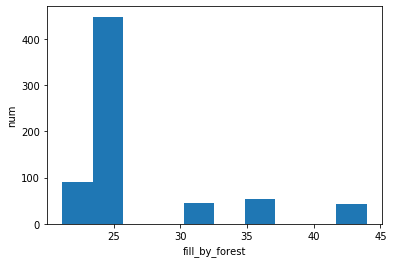

In [110]:
plt.hist(fill_y_forest);plt.xlabel('fill_by_forest');plt.ylabel('num')

Text(0, 0.5, 'num')

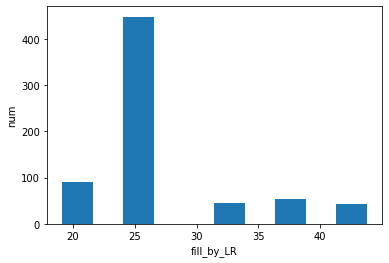

In [111]:
plt.hist(fill_y_LR);plt.xlabel('fill_by_LR');plt.ylabel('num')

Text(0, 0.5, 'fill_by_LR')

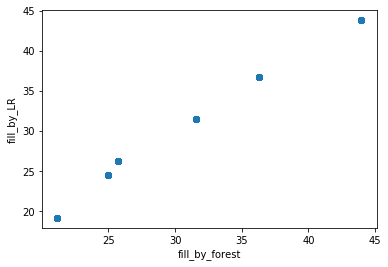

In [112]:
plt.scatter(fill_y_forest,fill_y_LR);plt.xlabel('fill_by_forest');plt.ylabel('fill_by_LR')

### 结果分析
- 填充的值大部分是25岁的
- 两种回归方法的预测结果极为相似，几乎就分布在y=x轴上

## 聚类方法——K-means聚类

### 重新组织数据
* 考虑到row.names,names对于聚类分析意义不大，故去除
* 特征room,ticket,boat等特征缺失过多，不能用于分析，同时也对填补工作不利，故去除
* 考虑到之前分析过性别与年龄之间关联性几乎没有，所以同样去除

In [113]:
titanic_new2=titanic.drop(feature_names[[0,3,5,6,7,8,9,10]], axis='columns') 
titanic_knn=titanic_new2.drop(['age'], axis='columns') 
titanic_onehot2, titanic_n = one_hot_dataframe(titanic_knn, ['pclass', 'survived'], replace=True)
titanic_onehot2.tail()

,pclass=1st,pclass=2nd,pclass=3rd,survived
1308,0.0,0.0,1.0,0.0
1309,0.0,0.0,1.0,0.0
1310,0.0,0.0,1.0,0.0
1311,0.0,0.0,1.0,0.0
1312,0.0,0.0,1.0,0.0


#### 3种舱，2种性别，2种结局（生死）—— 3\*2=6

In [114]:
from sklearn import cluster
# 预知聚类数取为 6
km = cluster.KMeans(init='k-means++', n_clusters=6, random_state=42)#预知聚类数取为 4

In [115]:
titanic_onehot2_data=np.array(titanic_onehot2)
km.fit(titanic_onehot2_data)

KMeans(n_clusters=6, random_state=42)

In [116]:
km.cluster_centers_

array([[ 1.00000000e+00, -4.71844785e-16,  1.11022302e-16,
         1.00000000e+00],
       [ 4.71844785e-16, -6.10622664e-16,  1.00000000e+00,
        -2.77555756e-16],
       [ 1.66533454e-16,  1.00000000e+00,  2.22044605e-16,
        -2.77555756e-16],
       [-1.38777878e-16, -5.55111512e-17,  1.00000000e+00,
         1.00000000e+00],
       [ 1.00000000e+00, -1.38777878e-16,  1.11022302e-16,
        -2.22044605e-16],
       [-1.94289029e-16,  1.00000000e+00,  1.11022302e-16,
         1.00000000e+00]])

### 六种类别的含义：
- 一等舱，生存
- 三等舱，死亡
- 二等舱，死亡
- 三等船，生存
- 一等舱，死亡
- 二等舱，生存

### 填充
- 对六个类中的已知年龄求平均值mean[i]
- 在每一类中对缺失值分别用该类的年龄均值进行填充

In [117]:
titanic_km=pd.DataFrame(np.hstack([np.array(titanic[['row.names','age']]),km.labels_.reshape(1313,1)]),
                        columns=['rows','age','label'])
age_fill=[]
mean=np.zeros(6)
for i in range(6):
    mean[i] = titanic_km[titanic_km['label']==i]['age'].mean() 
    rows_fill=[];rows=[];judge=[]
    rows = np.array(titanic_km[titanic_km['label']==i]['rows'])
    judge = np.array(titanic_km[titanic_km['label']==i]['age'].isna())
    for k in range(len(rows)):
        if judge[k]:
            rows_fill.append(rows[k])
    for j in range(len(rows_fill)):
        titanic_km.loc[[rows_fill[j]-1],['age']]=mean[i] 
        age_fill.append(mean[i])
pd.DataFrame(np.transpose(mean),index=['1','2','3','4','5','6'],columns=['fill_age'])

,fill_age
1,36.776379
2,25.666666
3,31.672414
4,20.804348
5,44.287356
6,24.225694


### 分析
- 船舱
    - 一等舱：1,5
    - 二等舱：3,6
    - 三等舱：2,4
- 生存
    - 死亡：2,3,5
    - 生存：1,4,6


* 可见一等舱明显更年长，三等舱明显更年轻
* 推测是由于一等舱都是年长的富豪阔太，三等舱是想要前往新兴的美国探索新世界的年轻人打工仔
* 非常奇怪的是，死亡的人都是每个船舱等级中更年轻的人，可能是由于绅士的谦让和牺牲精神，把生还的希望都留给了老弱之人


Text(0, 0.5, 'num')

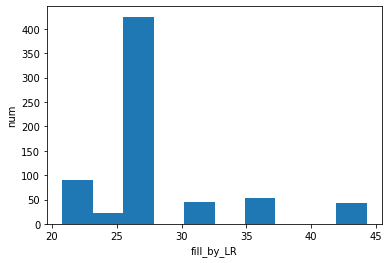

In [118]:
plt.hist(age_fill);plt.xlabel('fill_by_LR');plt.ylabel('num')

- 从分布上看，与回归方法填充类似

#### 与回归方法的填充值进行比较
- 虽然所填充的数值和分布类似
- 但是对于在聚类方法中填“25岁”的乘客在回归方法中所填数值在20-45岁不等
- 相反，回归方法中填“20，25岁”的客在聚类方法中所填数值在20-45岁不等

Text(0, 0.5, 'fill_by_k-means')

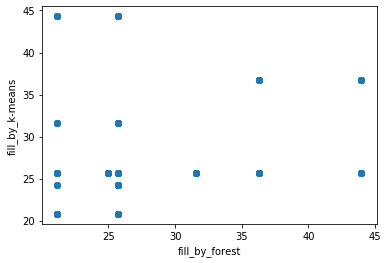

In [119]:
plt.scatter(fill_y_forest,age_fill)
plt.xlabel('fill_by_forest')
plt.ylabel('fill_by_k-means')

## 总结
- 总的来说，数据集缺失数据较多，要想用其他已知的特征反过来填补缺失的年龄，可用的数据不多
- 其次，在可以用于推测年龄的特征中，与年龄有较大关联的只有船舱等级pclass
- 由于数据缺乏，将幸存与否“survived”也加入了推测年龄的特征中，其实他们之间的关联性并不强。
- 采用回归方法所预测的结果不同方法之间十分相近，采用聚类方法与回归方法之间有较大的不同
- 总体来说，我认为比起简单的用均值填充，这样的回归和聚类方法的填充总体是更优的。